# Pregunta  1

El problema XOR es un problema de clasificación donde los datos, en este caso puntos en el rectángulo $[-1,1]\times[-1,1]$ poseen etiquetas correspondientes al resultado de la función lógica XOR dadas sus coordenadas espaciales. Por ejemplo, $ XOR(-0.11,-0.89) = -1$, $XOR(-0.56, 0) = 1$, y así. 

La regla XOR por lo tanto particiona el espacio en dos clases disjuntas, los cuadrantes 1 y 3 pertenecen a la clase donde $XOR(x_1,x_2) = -1$ (pues sus signos coinciden) y los cuadrantes 2 y 4 pertenecen a la clase donde $XOR(x_1, x_2) = 1$ (pues sus signos difieren). Dicho particionamiento hace que la clasificación sea un problema no linealmente separable.

## a) Generación de data para XOR

In [1]:
import numpy as np

In [2]:
def do_XOR(n=1000,noisy_n=100,svm=False, rnd_state=0):
    rng = np.random.RandomState(rnd_state)
    X_train = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_train = np.logical_xor(X_train[:,0] > 0, X_train[:,1] > 0)
    Y_train = 2*Y_train-1 if svm else Y_train
    X_noisy= rng.uniform(low=-0.8,high=0.2,size=(noisy_n,2))
    Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
    Y_noisy = 2*Y_noisy-1 if svm else Y_noisy
    X_train = np.vstack((X_train, X_noisy))
    Y_train = np.hstack((Y_train, Y_noisy))
    X_test = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    Y_test = 2*Y_test - 1 if svm else Y_test
    return X_train,Y_train,X_test,Y_test

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_dataset(X_train, Y_train, X_test, Y_test):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,8))
    ax1.set_title("Train data", fontsize=20)
    ax1.grid(color='k', linestyle='--', linewidth=1)
    class1 = Y_train == 1
    class2 = Y_train == 0
    ax1.plot(X_train[class1, 0], X_train[class1, 1], 'bo', mew=0, label=r"$XOR(x_1, x_2) = 1$")
    ax1.plot(X_train[class2, 0], X_train[class2, 1], 'ro', mew=0, label=r"$XOR(x_1, x_2) = 0$")
    ax1.set_xticks([-1, 0, 1])
    ax1.set_yticks([-1, 0, 1])
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width, box.height])
    plt.grid()
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), fontsize=20)

    ax2.set_title("Test data", fontsize=20)
    ax2.grid(color='k', linestyle='--', linewidth=1)
    class1 = Y_test == 1
    class2 = Y_test == 0
    ax2.plot(X_test[class1, 0], X_test[class1, 1], 'ro', mew=0, label=r"$XOR(x_1, x_2) = 1$")
    ax2.plot(X_test[class2, 0], X_test[class2, 1], 'bo', mew=0, label=r"$XOR(x_1, x_2) = 0$")
    ax2.set_xticks([-1, 0, 1])
    ax2.set_yticks([-1, 0, 1])
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width, box.height])
    ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), fontsize=20)
    plt.show()

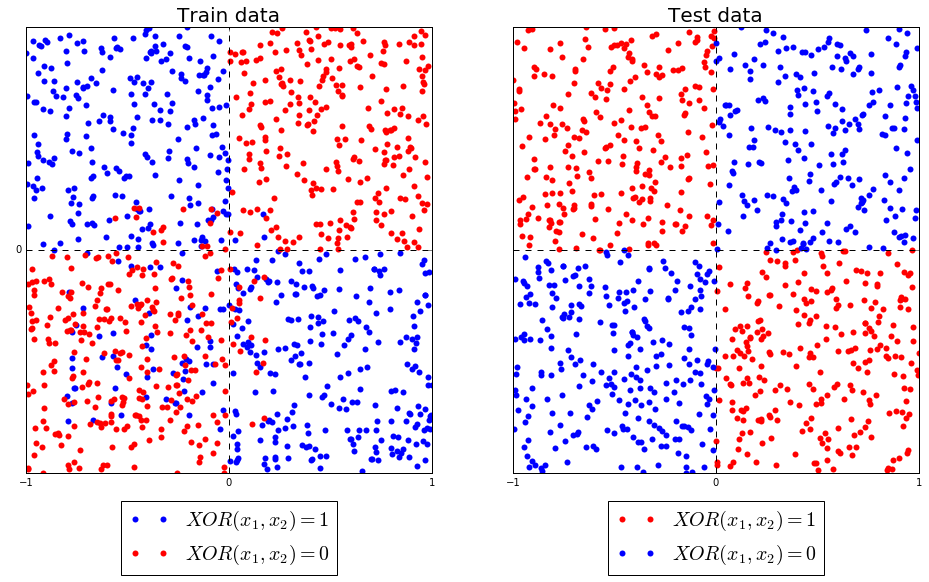

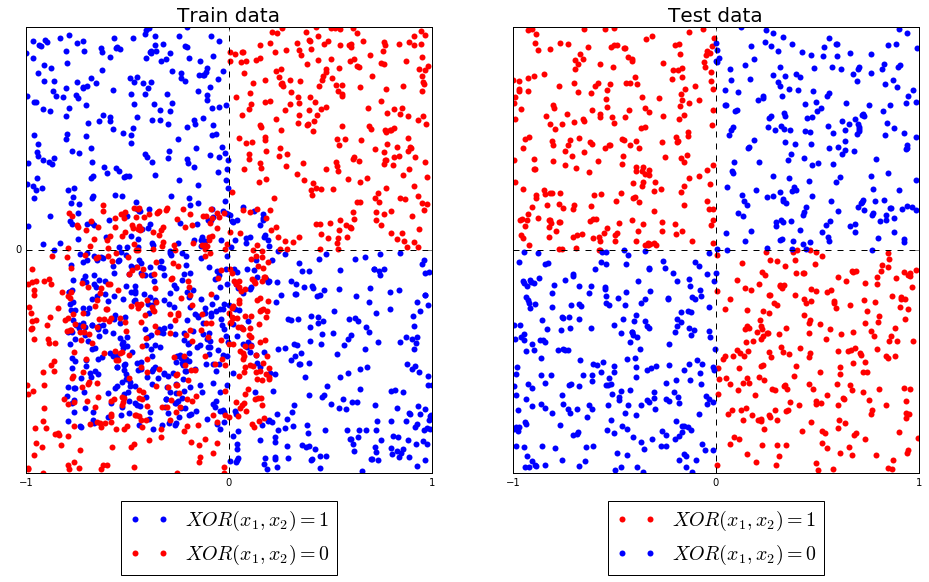

In [4]:
X_train, Y_train, X_test, Y_test = do_XOR(noisy_n=100)
plot_dataset(X_train, Y_train, X_test, Y_test)
X_train, Y_train, X_test, Y_test = do_XOR(noisy_n=500)
plot_dataset(X_train, Y_train, X_test, Y_test)

## b) SVM Lineal para resolver XOR

In [5]:
X_train, Y_train, X_test, Y_test = do_XOR(noisy_n=100)

In [6]:
from matplotlib import colors
background_cmap = colors.ListedColormap(['#9690FF', '#FFA6A6'])
dots_cmap = colors.ListedColormap(['#000595', '#EB0000'])

def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type, title):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(20, 20))
    axis.set_title(title, fontsize=20)
    axis.scatter(X_train[:,0],X_train[:,1],s=15,c=Y_train,zorder=10,cmap=dots_cmap, edgecolor='',marker='d')
    axis.scatter(X_test[:,0],X_test[:,1],s=30,c=Y_test,zorder=10,cmap=dots_cmap, edgecolor='',marker='o')
    XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
    if model_type == 'svm':
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    elif model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
    axis.pcolormesh(XX, YY, Zplot ,cmap=background_cmap)
    axis.contour(XX, YY, Z, alpha=1, colors=['k','k','k'],
    linestyles=['--', '--', '--'],levels=[-1, 0, 1],linewidths=[2,2,2])
    plt.show()

In [7]:
from sklearn.svm import LinearSVC

svms_group1 = []
svms_group2 = []
svms_group3 = []

K = np.arange(-4, 5, 1)
C = np.power(2.0, K)
for c in C:
    print "Resultados para c =",c
    svm = LinearSVC(C=c, penalty='l2', dual=False)
    svm.fit(X_train, Y_train)
    svms_group1.append(svm)
    print "\t Sin resolver problema dual, pérdida L2. \t Score:", svm.score(X_test, Y_test)
    
    svm = LinearSVC(C=c, penalty='l1', dual=False)
    svm.fit(X_train, Y_train)
    svms_group2.append(svm)
    print "\t Sin resolver problema dual, pérdida L1. \t Score:", svm.score(X_test, Y_test)
    
    svm = LinearSVC(C=c, penalty='l2', dual=True)
    svm.fit(X_train, Y_train)
    svms_group3.append(svm)
    print "\t Con resolver problema dual, pérdida L2. \t Score:", svm.score(X_test, Y_test)
    
    print 

Resultados para c = 0.0625
	 Sin resolver problema dual, pérdida L2. 	 Score: 0.471
	 Sin resolver problema dual, pérdida L1. 	 Score: 0.487
	 Con resolver problema dual, pérdida L2. 	 Score: 0.471

Resultados para c = 0.125
	 Sin resolver problema dual, pérdida L2. 	 Score: 0.471
	 Sin resolver problema dual, pérdida L1. 	 Score: 0.489
	 Con resolver problema dual, pérdida L2. 	 Score: 0.471

Resultados para c = 0.25
	 Sin resolver problema dual, pérdida L2. 	 Score: 0.471
	 Sin resolver problema dual, pérdida L1. 	 Score: 0.48
	 Con resolver problema dual, pérdida L2. 	 Score: 0.471

Resultados para c = 0.5
	 Sin resolver problema dual, pérdida L2. 	 Score: 0.471
	 Sin resolver problema dual, pérdida L1. 	 Score: 0.477
	 Con resolver problema dual, pérdida L2. 	 Score: 0.471

Resultados para c = 1.0
	 Sin resolver problema dual, pérdida L2. 	 Score: 0.471
	 Sin resolver problema dual, pérdida L1. 	 Score: 0.475
	 Con resolver problema dual, pérdida L2. 	 Score: 0.471

Resultados para

En general el parámetro de regularización mejora debilmente el rendimiento de la SVM, por otra parte la SVM con pérdida L1 posee mejores resultados que utilizando pérdida L2, y no se observan diferencias entre resolver el problema en su forma dual o no. Naturalmente estos scores no indican un buen rendimiento, de hecho al haber dos clases es mejor lanzar una moneda al aire y adivinar la clase, antes que utilizar una SVM lineal.

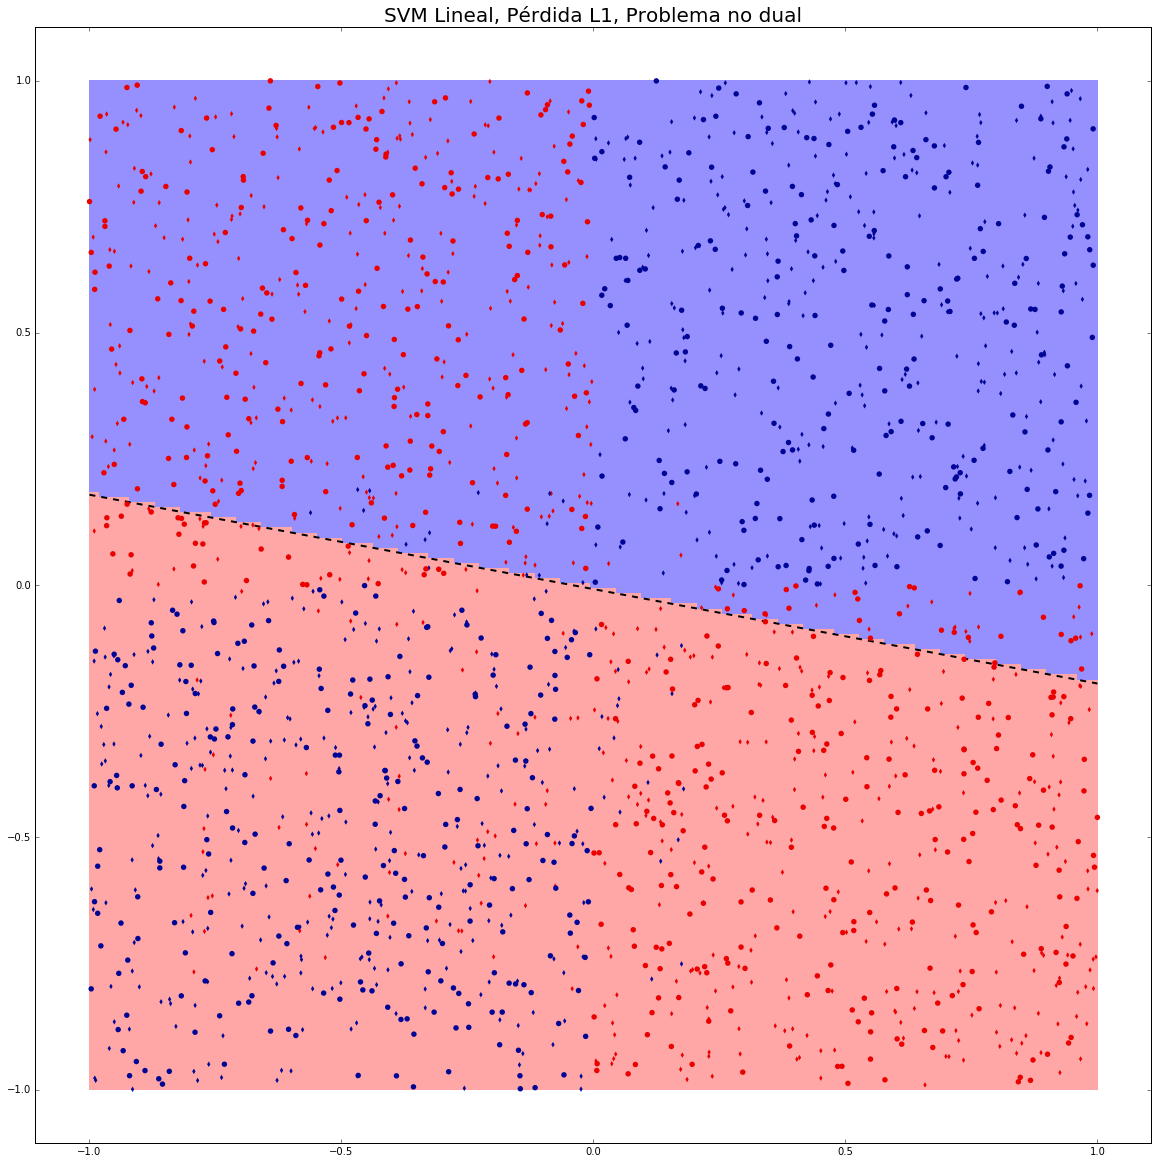

In [8]:
plot_classifier(svms_group2[1],X_train,Y_train,X_test,Y_test,'svm', u"SVM Lineal, Pérdida L1, Problema no dual")

Naturalmente la frontera generada es un hiperplano que no puede, por construcción, dividir las clases disjuntas destacadas en el gráfico. Hará falta otra clase de máquina con fronteras más flexibles, o con capacidad de fronteras disjuntas.

## c) SVM no lineal para resolver XOR

Train Accuracy = 0.885455
Test Accuracy = 0.944000


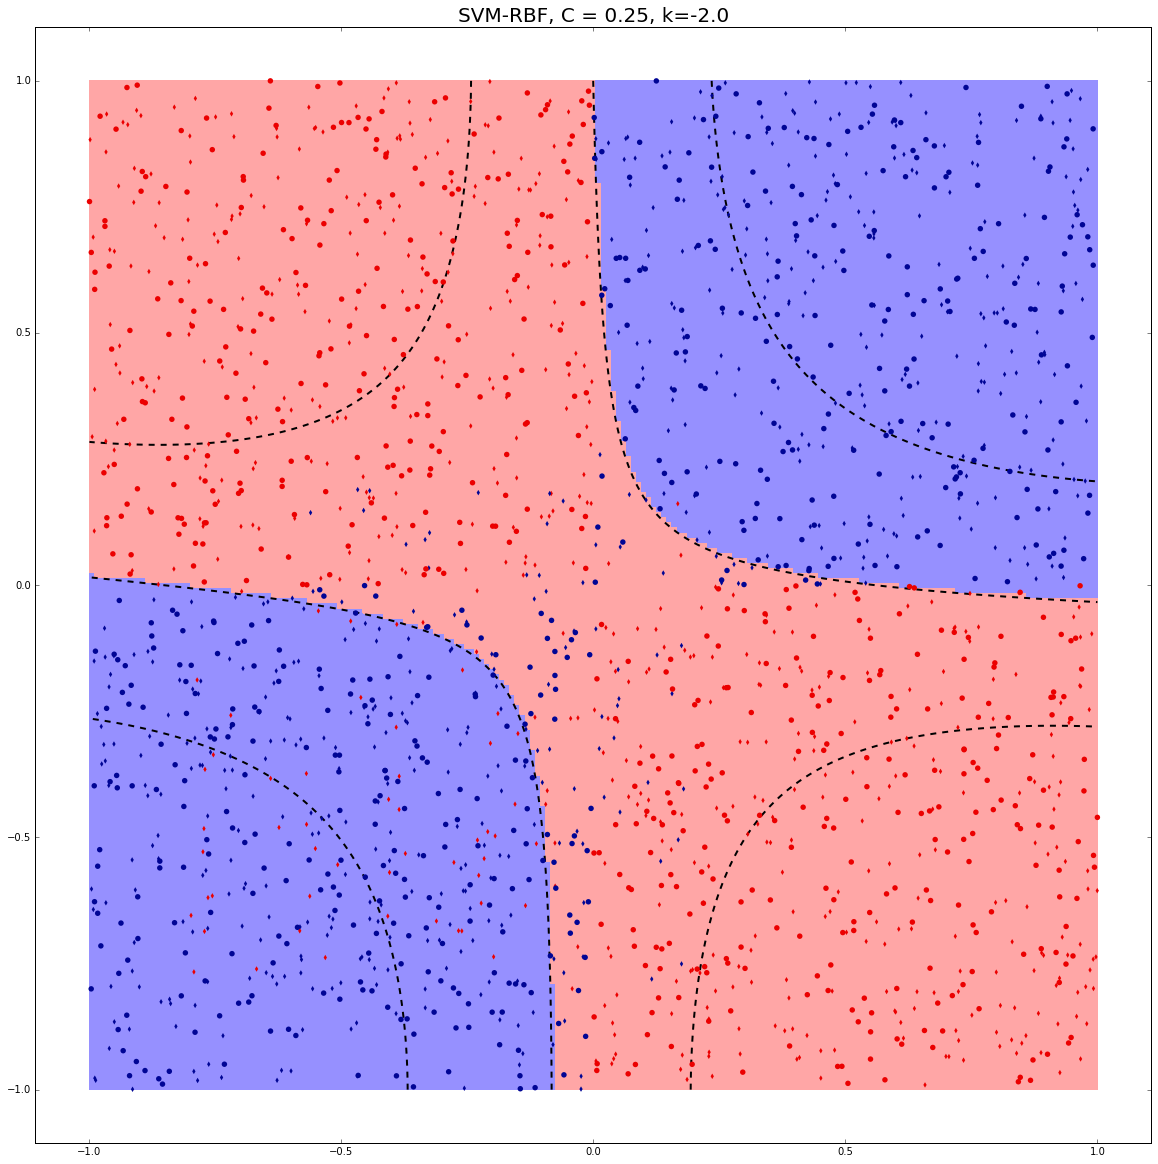

Train Accuracy = 0.880000
Test Accuracy = 0.935000


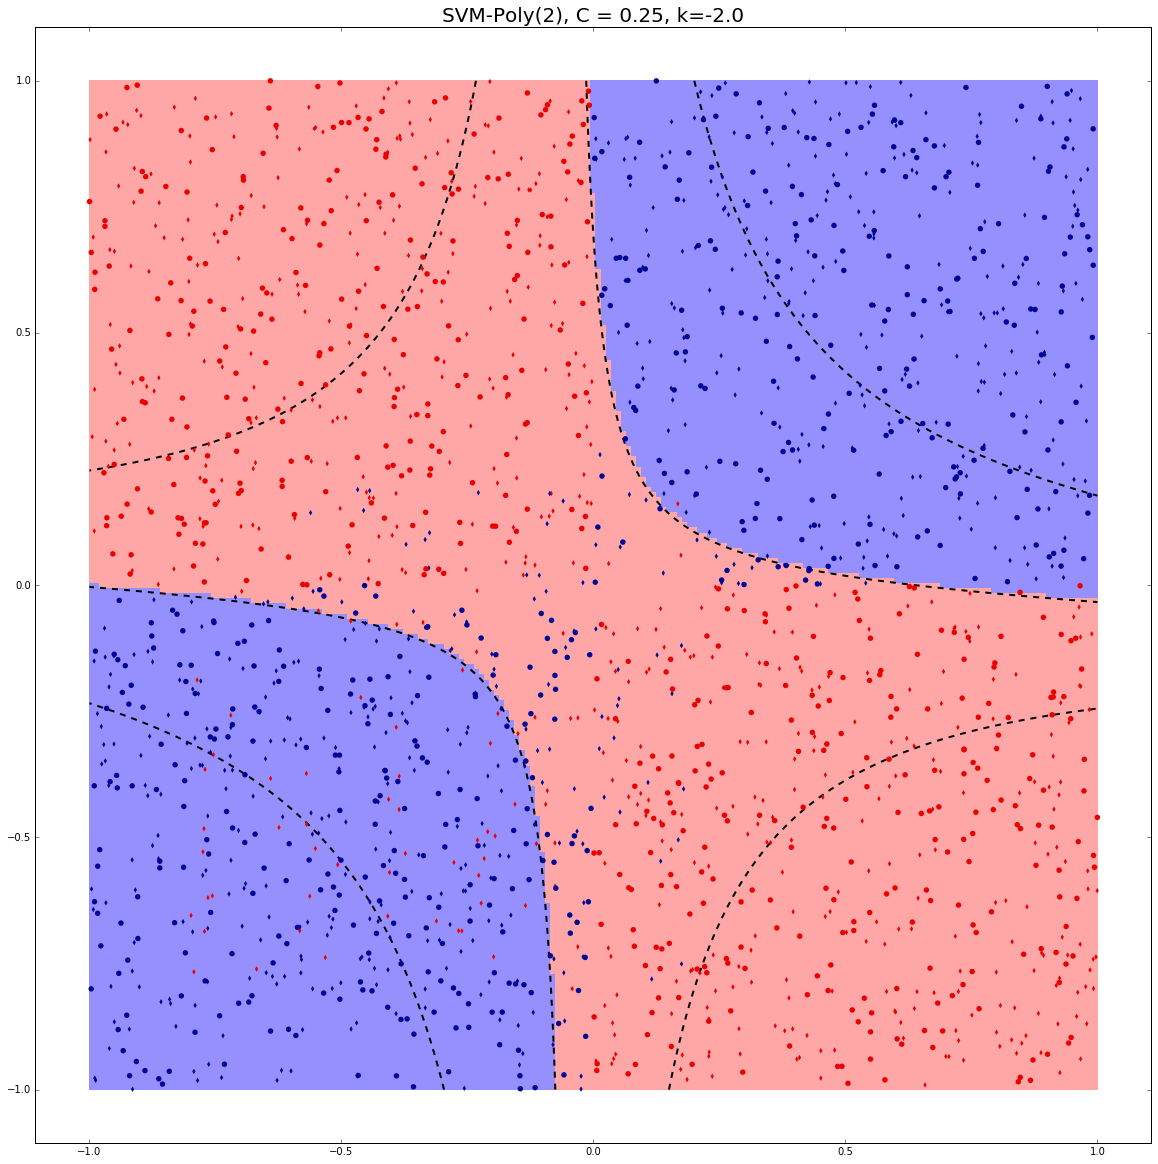

Train Accuracy = 0.890000
Test Accuracy = 0.959000


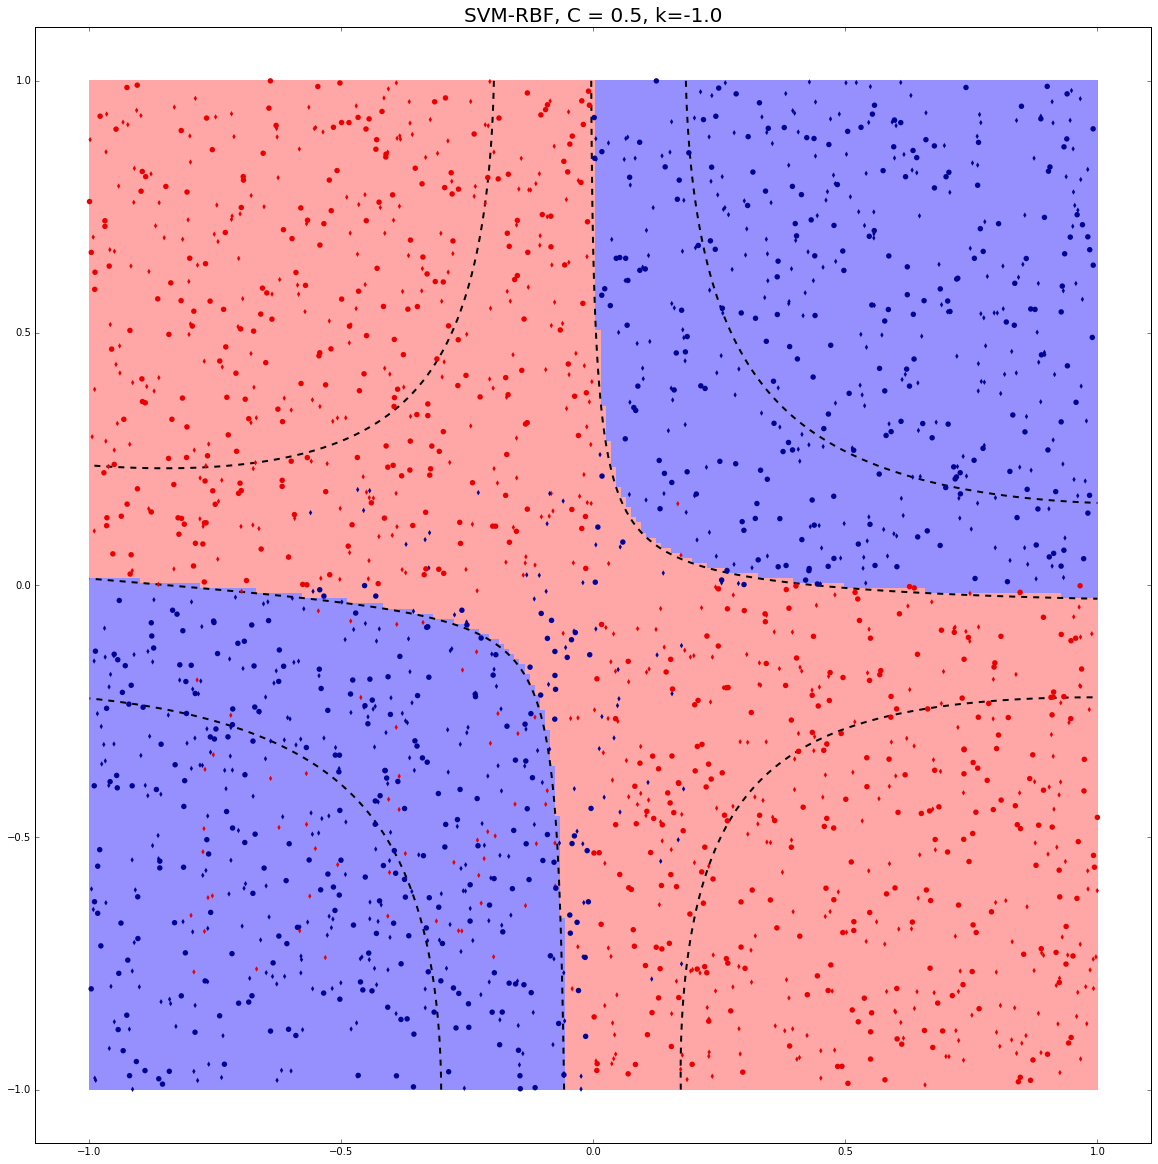

Train Accuracy = 0.887273
Test Accuracy = 0.943000


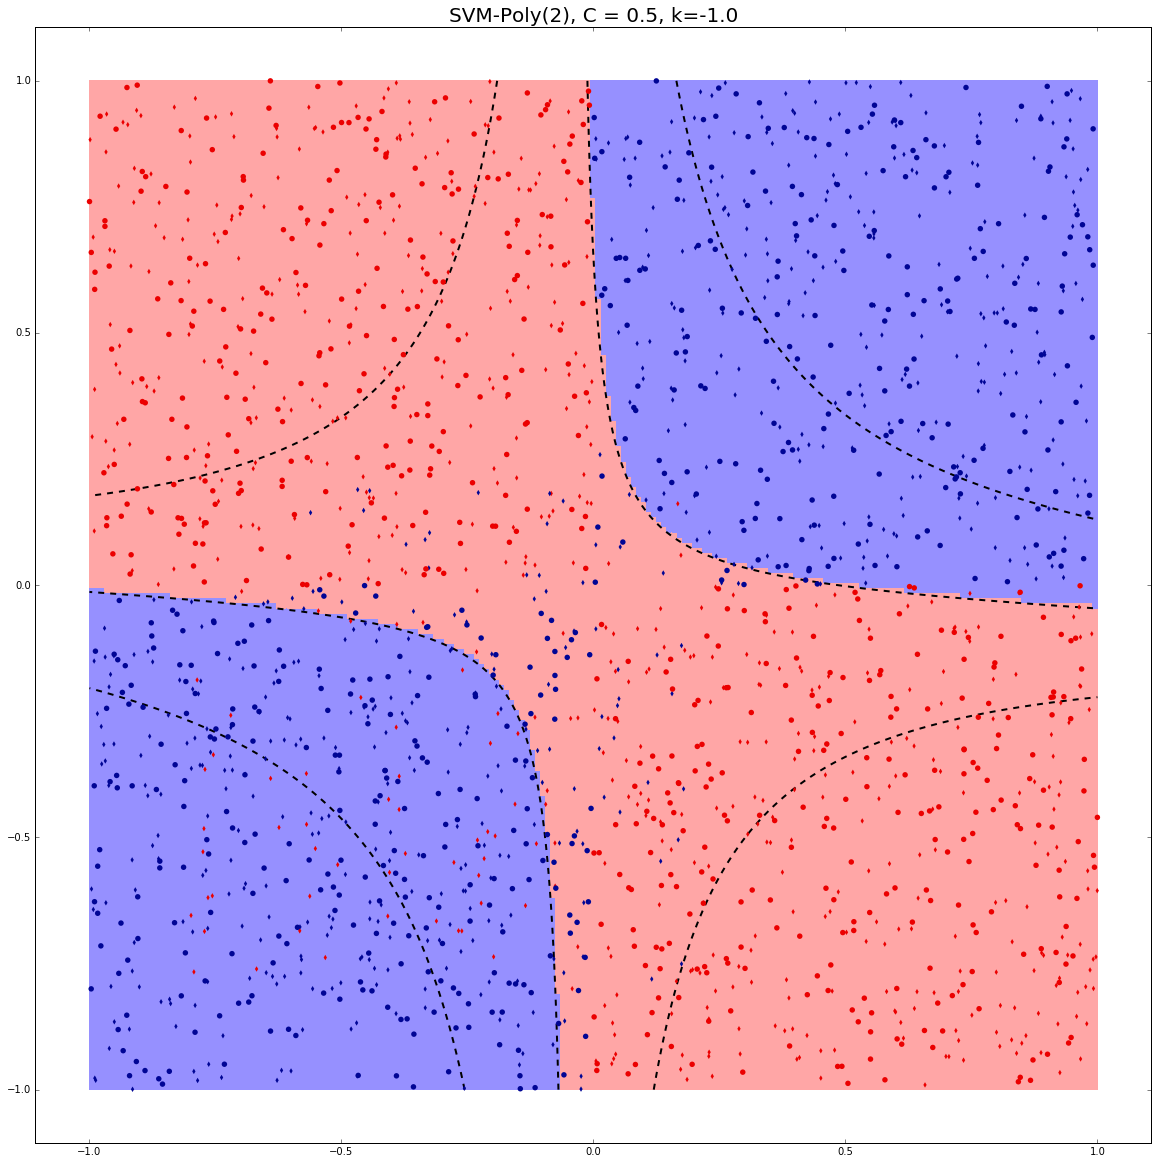

Train Accuracy = 0.887273
Test Accuracy = 0.954000


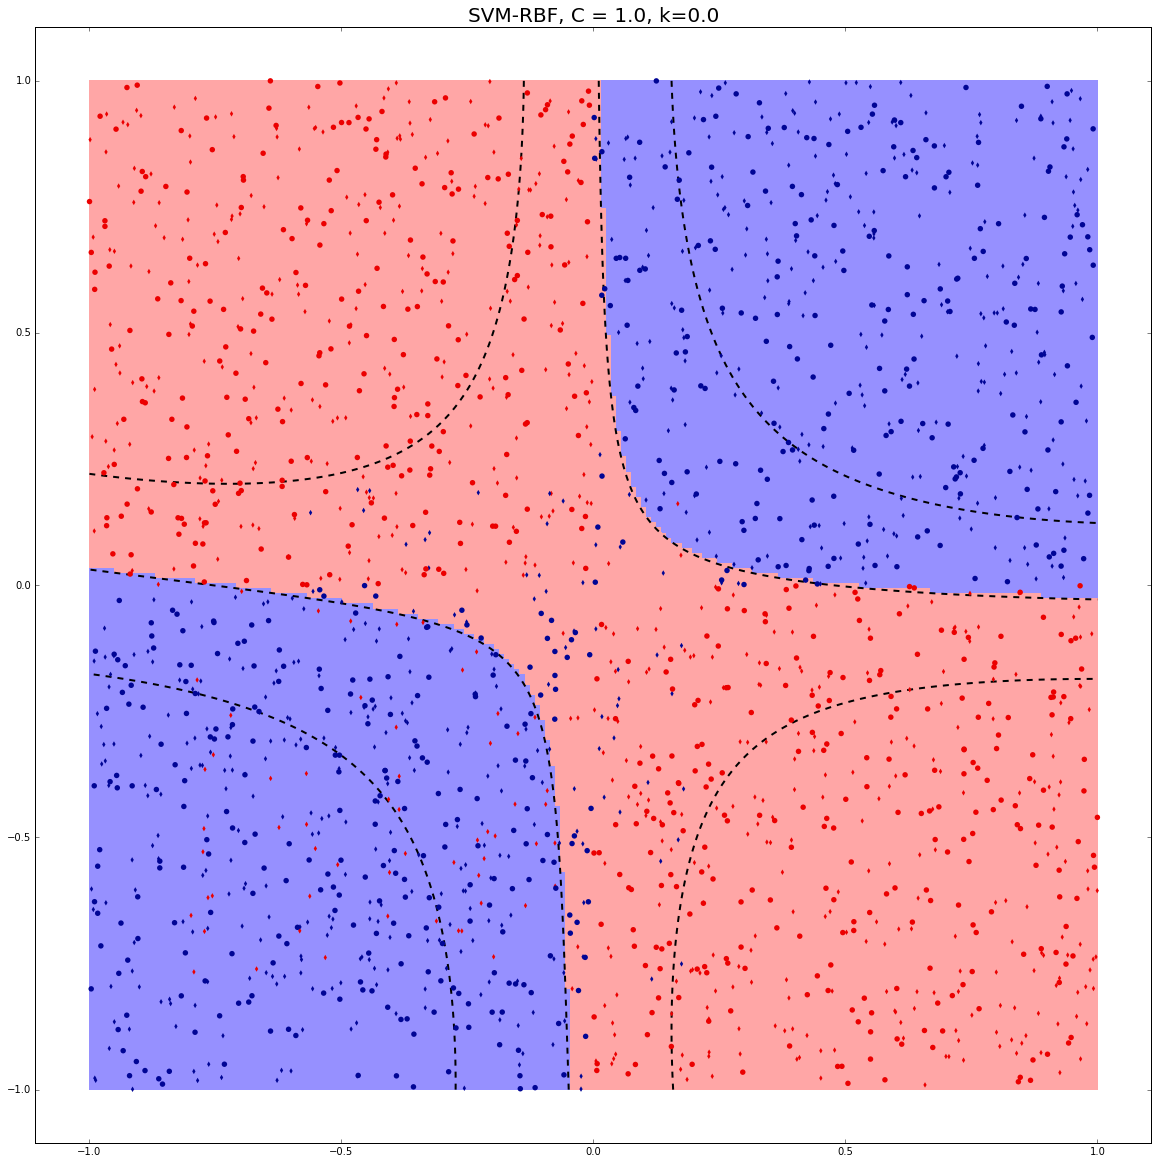

Train Accuracy = 0.888182
Test Accuracy = 0.952000


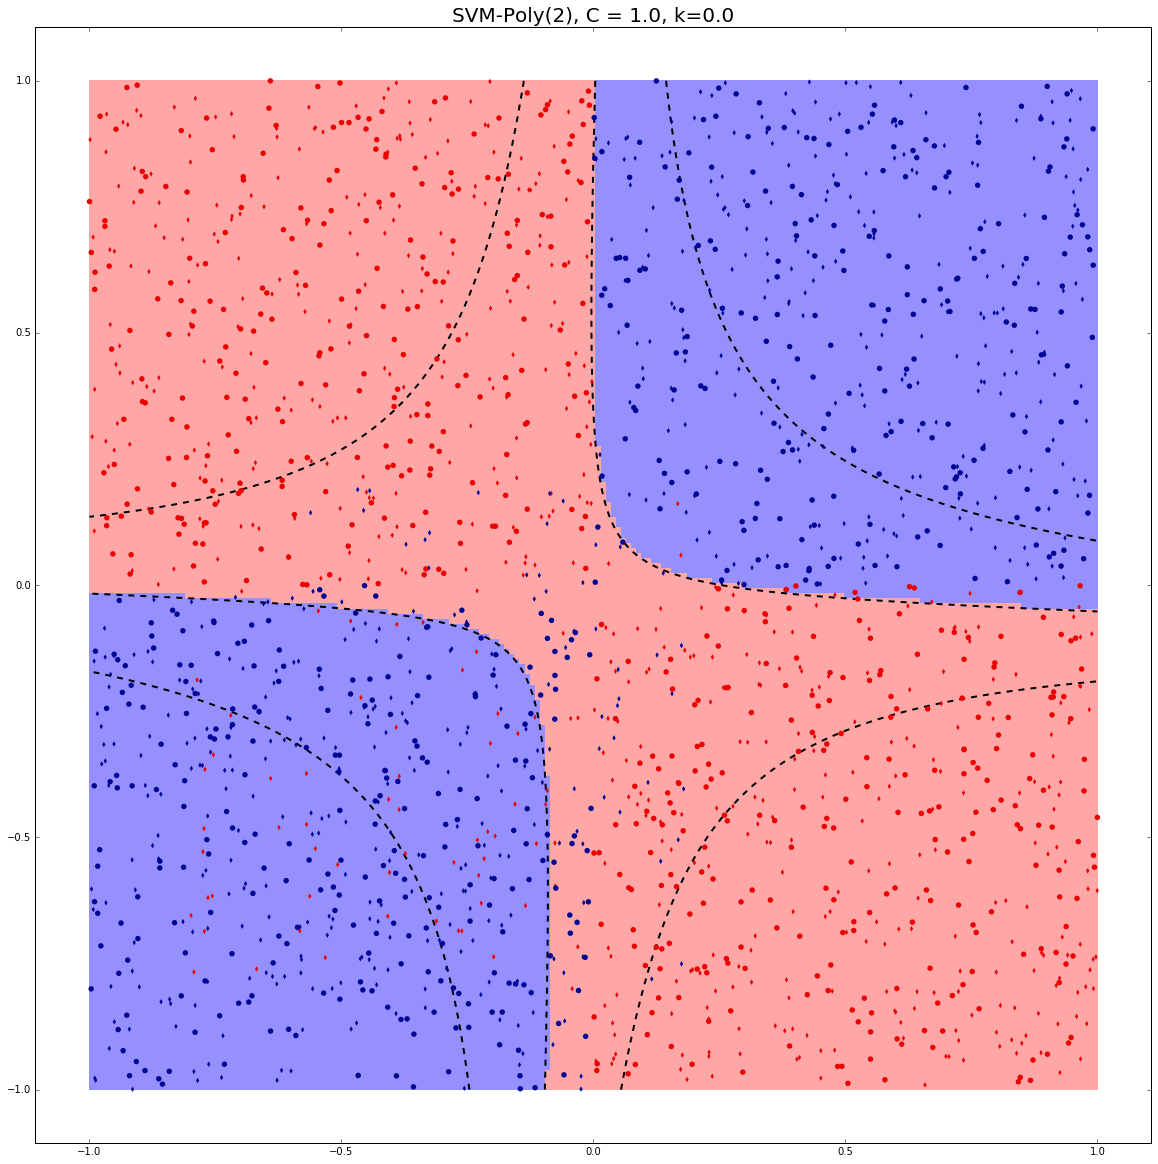

Train Accuracy = 0.890909
Test Accuracy = 0.959000


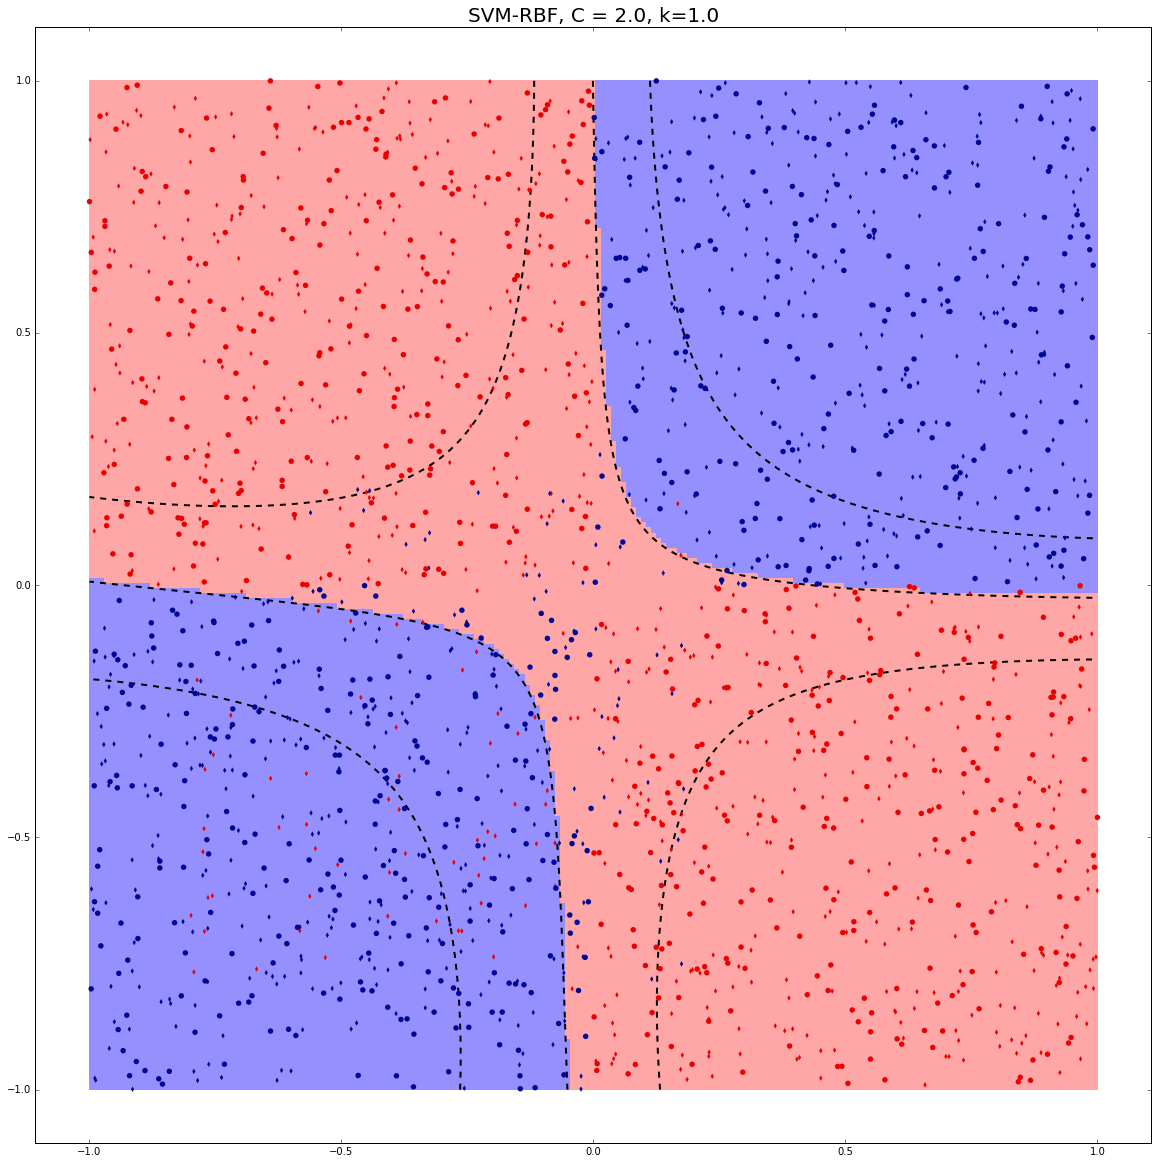

Train Accuracy = 0.883636
Test Accuracy = 0.943000


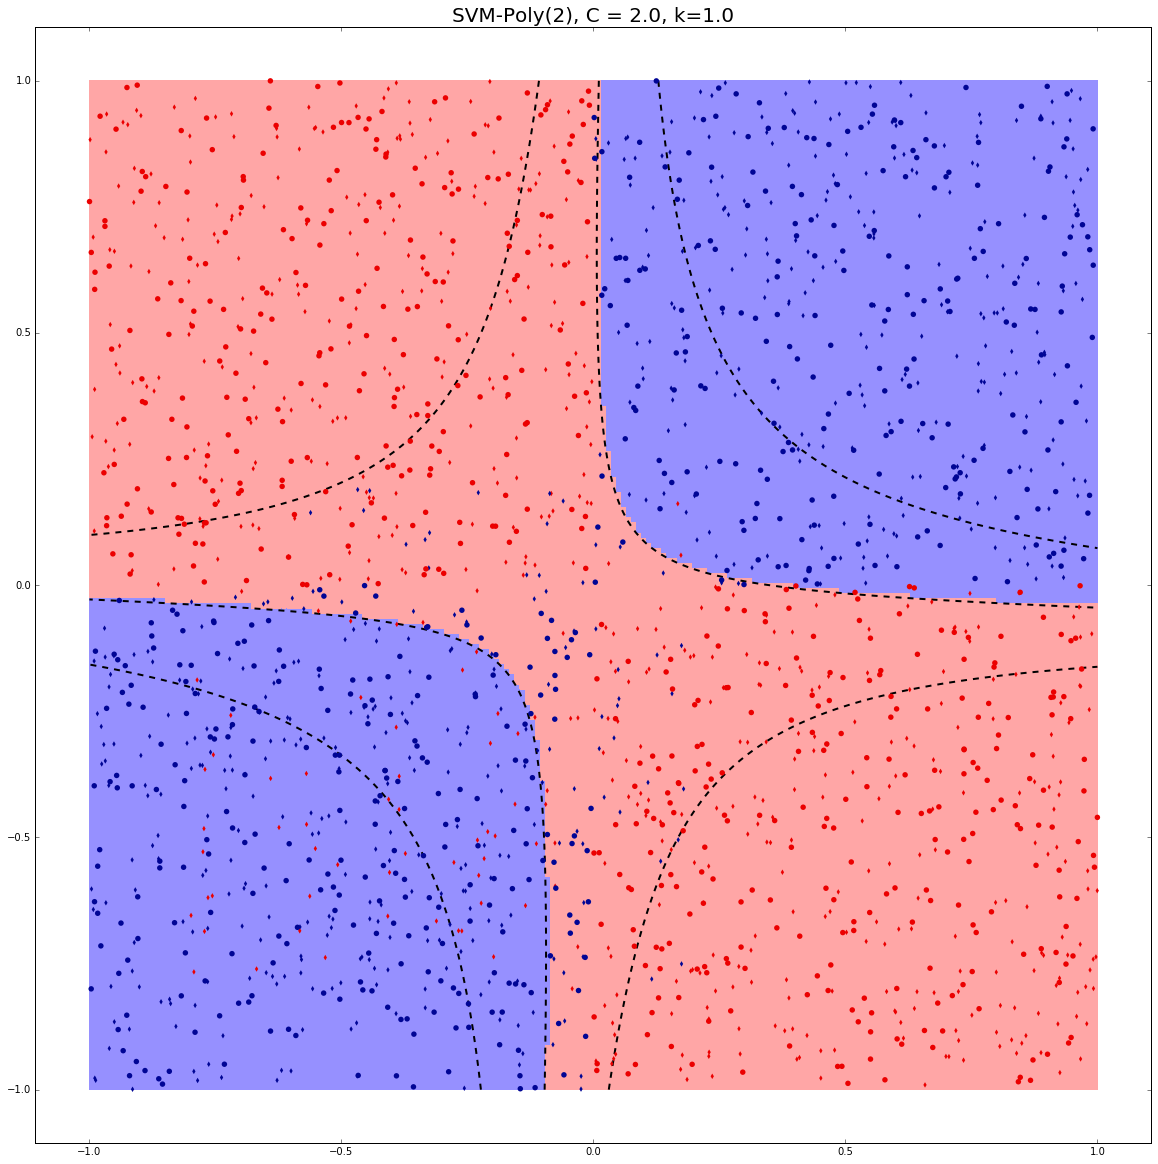

Train Accuracy = 0.901818
Test Accuracy = 0.970000


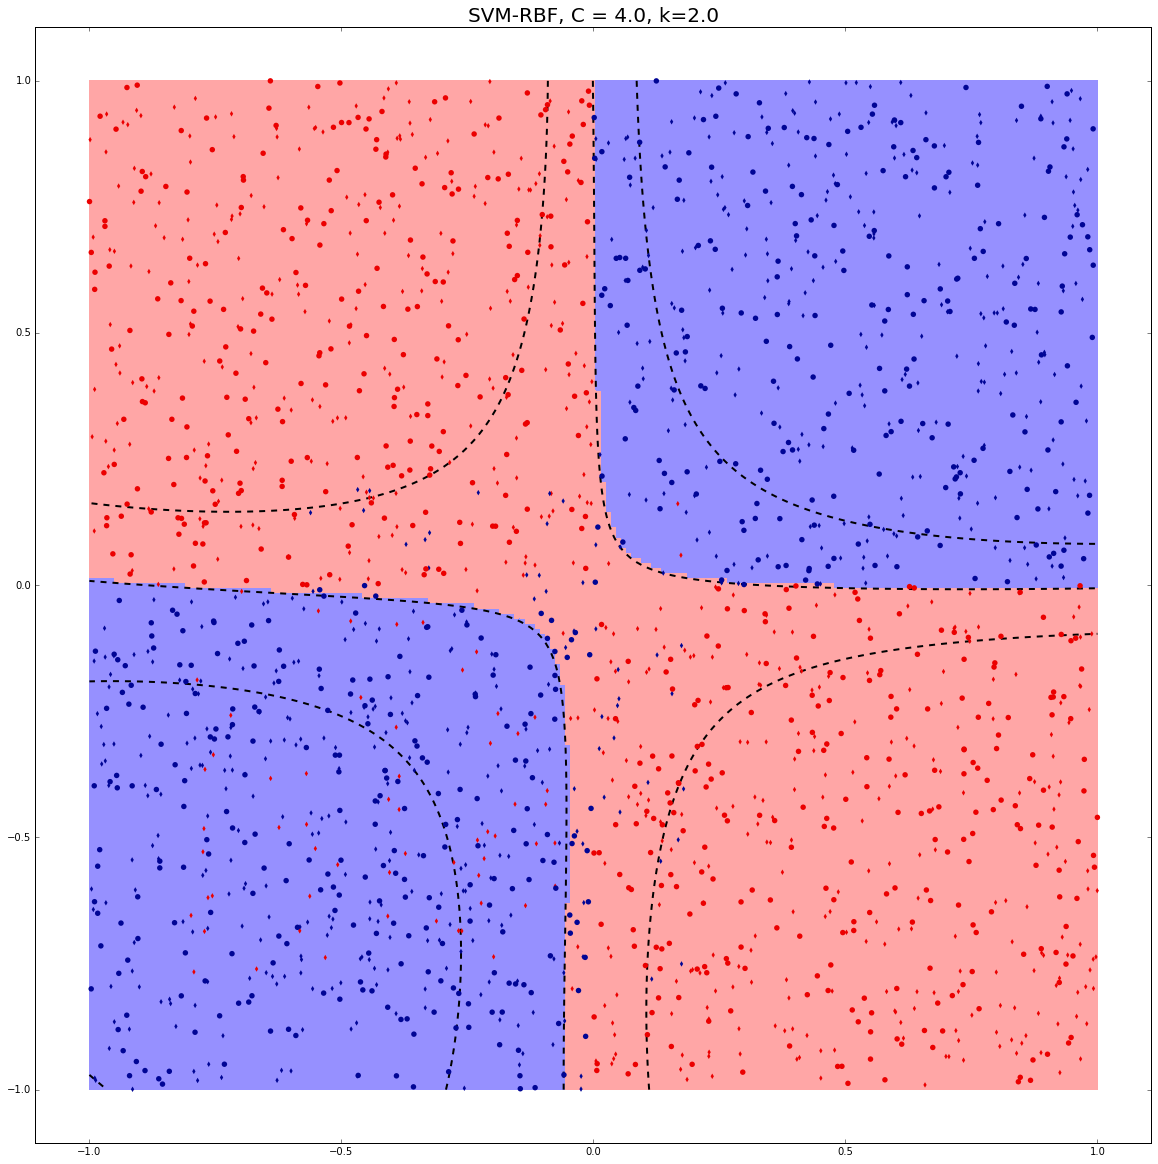

Train Accuracy = 0.887273
Test Accuracy = 0.946000


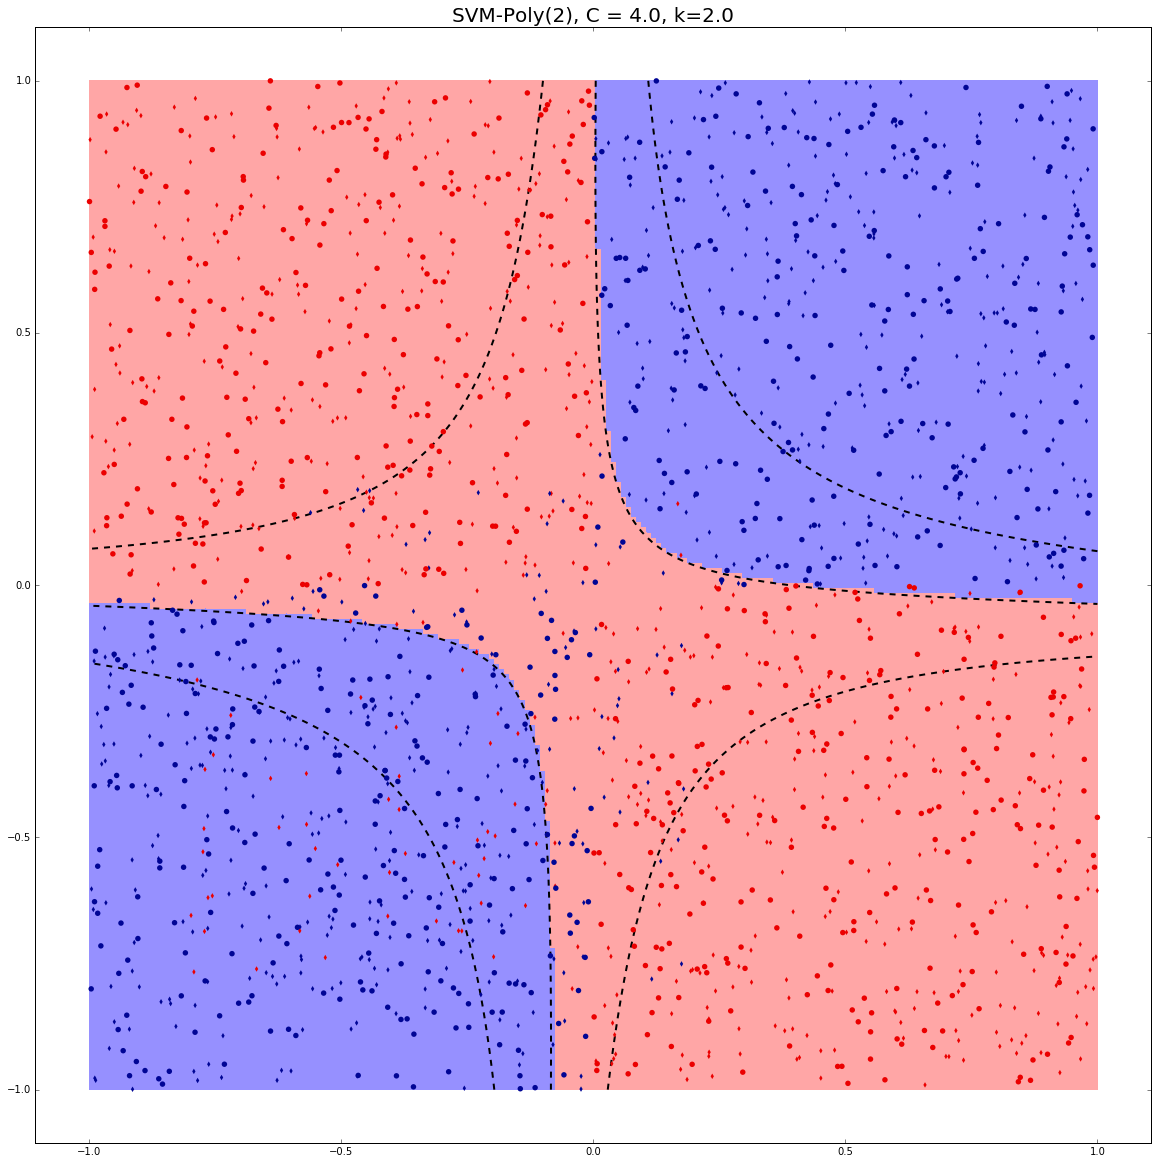

Train Accuracy = 0.902727
Test Accuracy = 0.972000


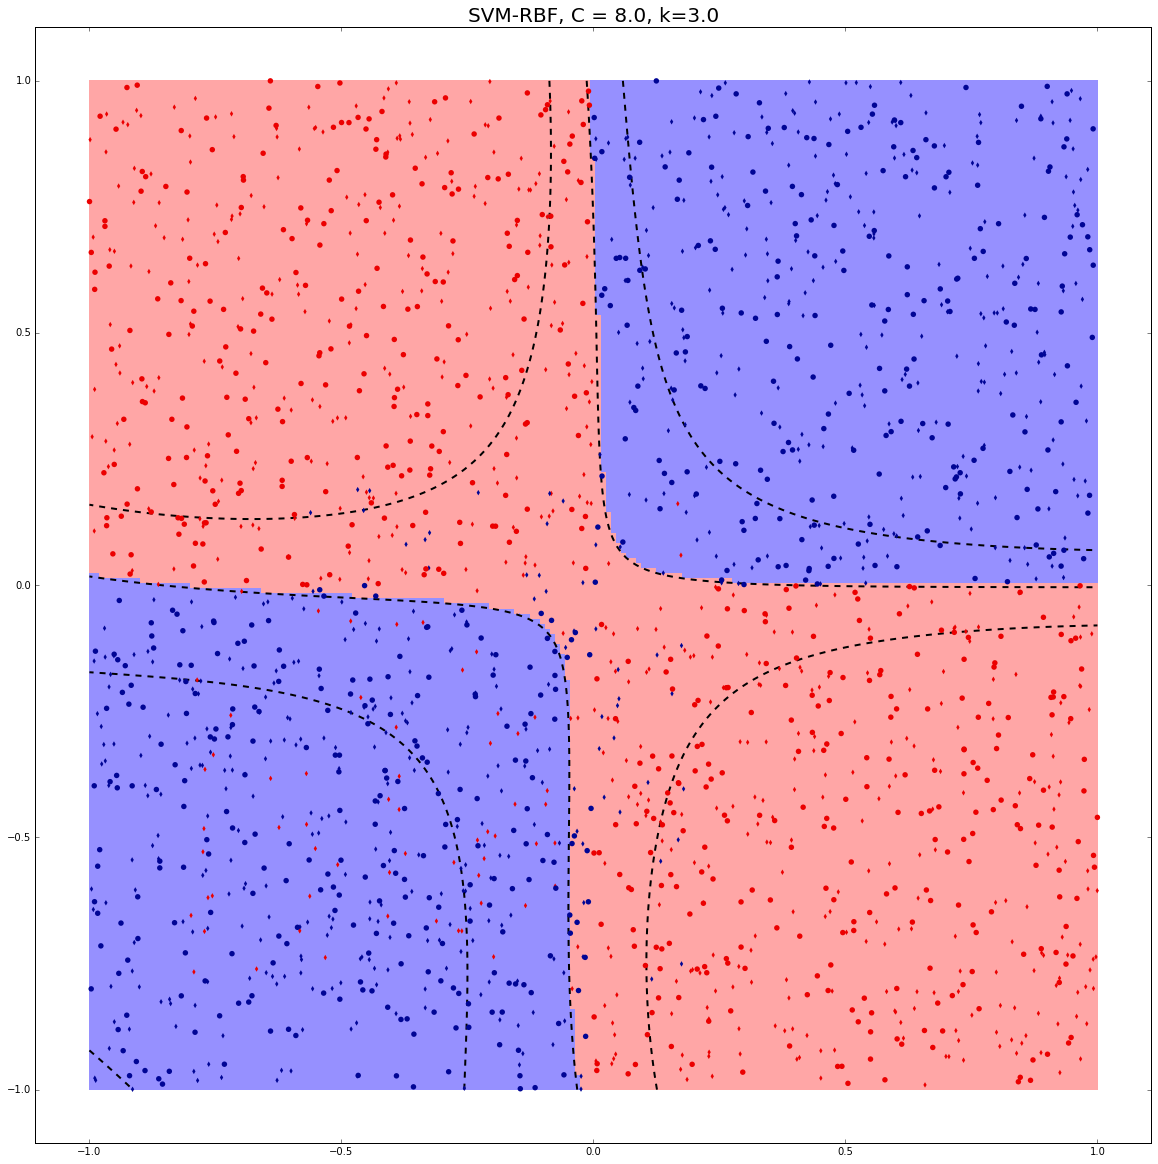

Train Accuracy = 0.887273
Test Accuracy = 0.955000


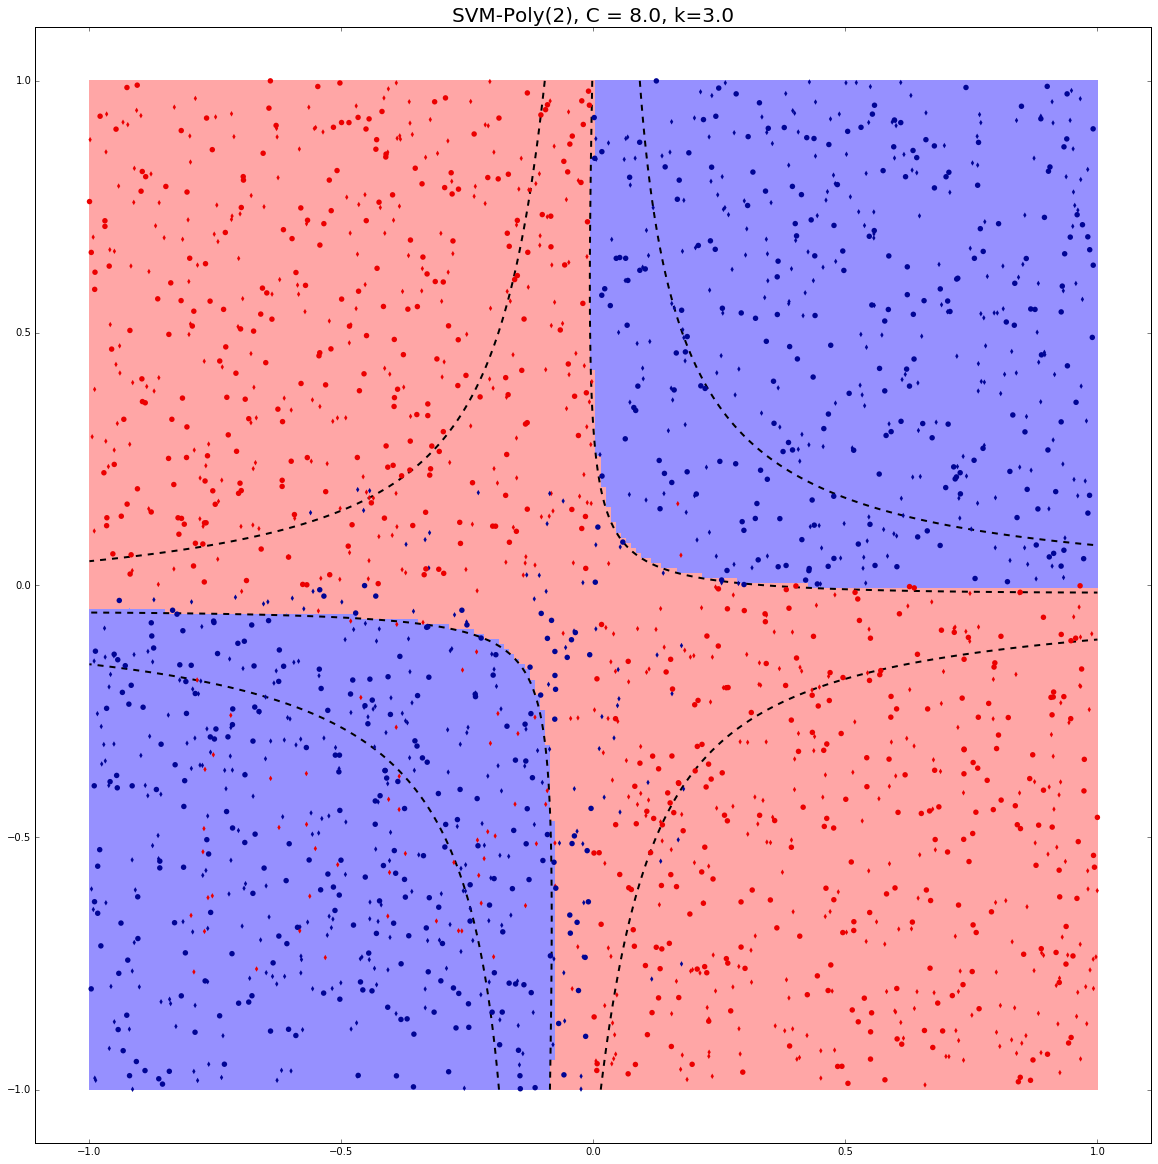

Train Accuracy = 0.898182
Test Accuracy = 0.970000


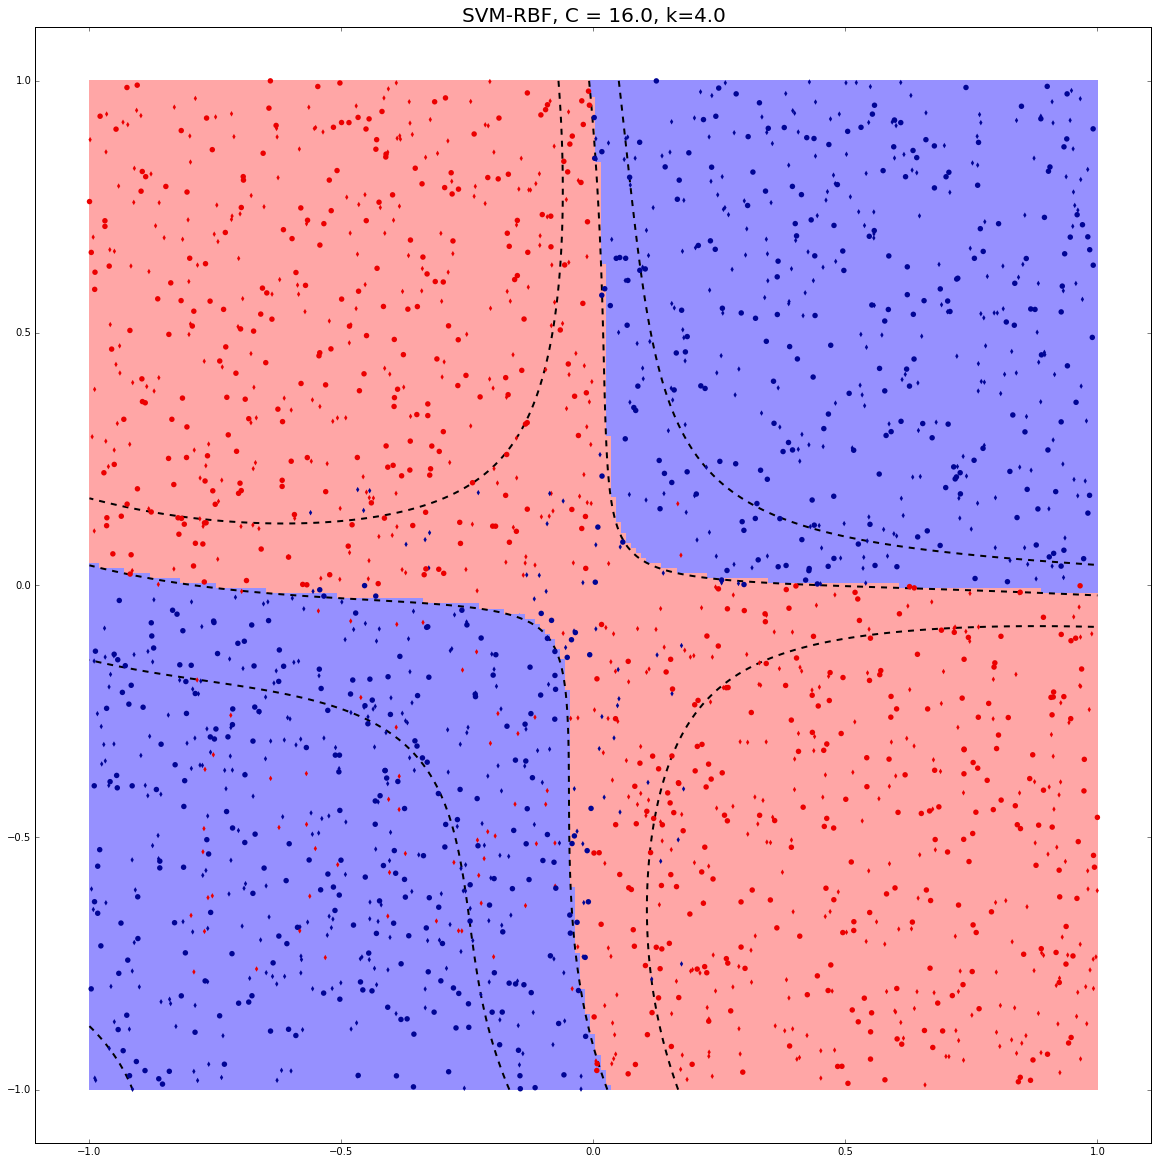

Train Accuracy = 0.890000
Test Accuracy = 0.949000


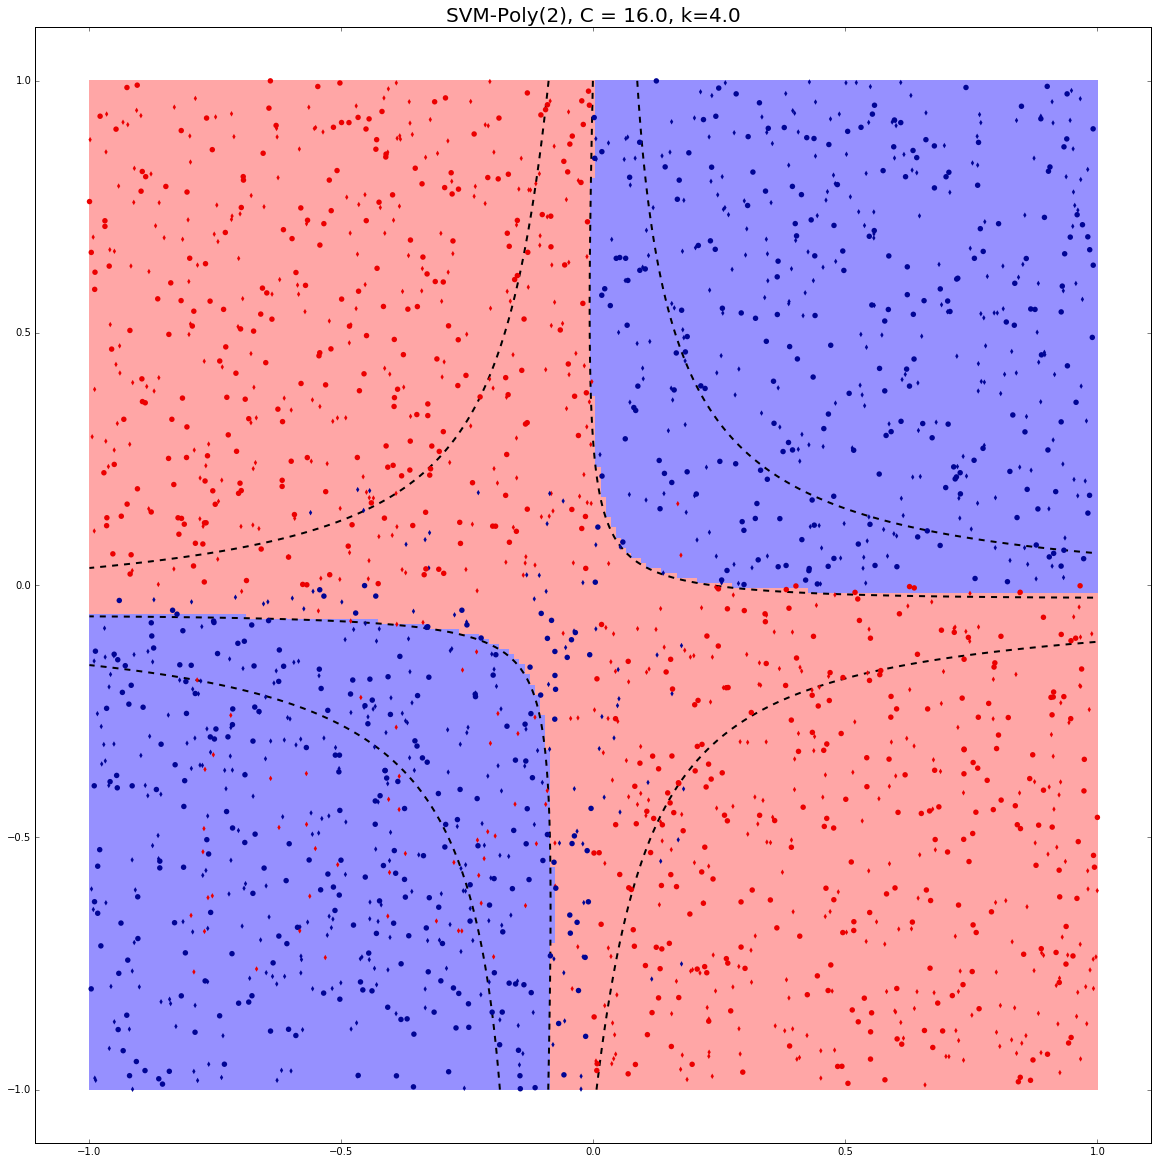

In [9]:
from sklearn.svm import SVC

train_accs_rbf = []
test_accs_rbf = []
train_accs_poly = []
test_accs_poly = []
K = np.arange(-2, 5, 1)
C = np.power(2.0, K)

for c in C:
    clf = SVC(C=c, kernel='rbf')
    clf.fit(X_train, Y_train)
    train_accs_rbf.append(clf.score(X_train,Y_train))
    test_accs_rbf.append(clf.score(X_test,Y_test))
    print "Train Accuracy = %f"%train_accs_rbf[-1]
    print "Test Accuracy = %f"%test_accs_rbf[-1]
    plot_classifier(clf,X_train,Y_train,X_test,Y_test,'svm','SVM-RBF, C = '+str(c)+', k='+str(np.log2(c)))
    
    clf = SVC(C=c, kernel='poly',degree=2, coef0=1)
    clf.fit(X_train, Y_train)
    train_accs_poly.append(clf.score(X_train,Y_train))
    test_accs_poly.append(clf.score(X_test,Y_test))
    print "Train Accuracy = %f"%train_accs_poly[-1]
    print "Test Accuracy = %f"%test_accs_poly[-1]
    plot_classifier(clf,X_train,Y_train,X_test,Y_test,'svm','SVM-Poly(2), C = '+str(c)+', k='+str(np.log2(c)))

En general los gráficos lucen similares, todos particionan la región en una región conexa para una clase y dos regiones disjuntas para la otra clase. La forma en que se dirime el límite de la región en el origen está relacionada también con la accuracy obtenida, pues se observa que mientras mejor se intenta aproximar la frontera en dicha zona, mejor es la accuracy. Por ejemplo, cualitativamente, el kernel RBF aproxima mejor esa zona sin descuidar el resto de las fronteras.

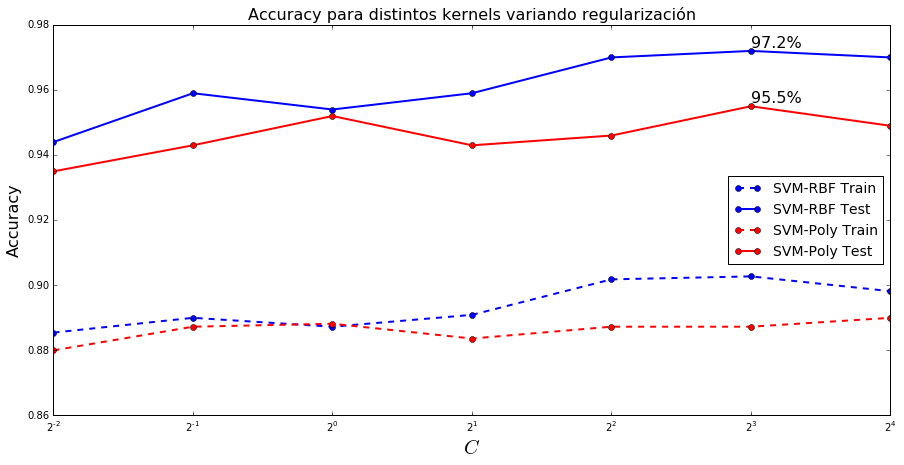

In [10]:
br_rbf_id = np.argmax(test_accs_rbf)
br_rbf = str(test_accs_rbf[br_rbf_id] * 100)+"%"

br_poly_id = np.argmax(test_accs_poly)
br_poly = str(test_accs_poly[br_poly_id] * 100)+"%"

plt.figure(figsize=(15, 7))
plt.title(u"Accuracy para distintos kernels variando regularización", fontsize=16)
plt.semilogx(C, train_accs_rbf, 'bo--', lw=2.0, label="SVM-RBF Train", basex=2)
plt.semilogx(C, test_accs_rbf, 'bo-', lw=2.0, label="SVM-RBF Test", basex=2)
plt.semilogx(C, train_accs_poly, 'ro--', lw=2.0, label="SVM-Poly Train", basex=2)
plt.semilogx(C, test_accs_poly, 'ro-', lw=2.0, label="SVM-Poly Test", basex=2)
plt.text(C[br_rbf_id], test_accs_rbf[br_rbf_id]+1e-3, br_rbf, fontsize=16)
plt.text(C[br_poly_id], test_accs_poly[br_poly_id]+1e-3, br_poly, fontsize=16)
plt.xlabel("$C$", fontsize=20)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(C)
plt.legend(loc='best', fontsize=14)
plt.show()

En el gráfico de accuracy como función de C podemos observar que, en primer lugar, con cualquiera de ambos kernels utilizados y un parámetro de regularización bien elegido obtenemos sobre un 95% de precisión en nuestros datos de prueba, lo que permite concluir que estamos resolviendo satisfactoriamente el problema de XOR (¡somos al menos 45% mejores que lanzando monedas!)

Los kernels implementados efectivamente particionan la región en dos conjuntos bastante similares a los teóricos. El mejor resultado obtenido es utilizando kernel RBF con 97.2% de precisión. El mejor resultado con kernel polinomial alcanza 95.5% de precisión, ambos utilizando como parámetro regulador C=8.

## d) Red neuronal de una capa para resolver XOR